In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings("ignore")

In [2]:
df_merged = pd.read_pickle("merged_data.pkl")

In [3]:
display(df_merged)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,product_category_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,São Paulo,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1.0,8683.0,54.0,64.0,31.0,-20.509897,-47.397866,franca,SP,office_furniture
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,São Paulo,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1.0,8683.0,54.0,64.0,31.0,-20.497396,-47.399241,franca,SP,office_furniture
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,São Paulo,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1.0,8683.0,54.0,64.0,31.0,-20.510459,-47.399553,franca,SP,office_furniture
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,São Paulo,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1.0,8683.0,54.0,64.0,31.0,-20.480940,-47.394161,franca,SP,office_furniture
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,São Paulo,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1.0,8683.0,54.0,64.0,31.0,-20.515413,-47.398194,franca,SP,office_furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17920941,7fb62e47282b83f023cf1fef8d8309c9,48f2f72862e37acc97f50b4484ee2af4,4319,sao paulo,São Paulo,c456339d894d329ad45d39e3d6796b90,delivered,2017-10-17 21:50:00,2017-10-17 22:05:18,2017-10-18 22:03:58,...,1.0,600.0,16.0,31.0,18.0,-23.647837,-46.633873,sao paulo,SP,garden_tools
17920942,7fb62e47282b83f023cf1fef8d8309c9,48f2f72862e37acc97f50b4484ee2af4,4319,sao paulo,São Paulo,c456339d894d329ad45d39e3d6796b90,delivered,2017-10-17 21:50:00,2017-10-17 22:05:18,2017-10-18 22:03:58,...,1.0,600.0,16.0,31.0,18.0,-23.646627,-46.638771,sao paulo,SP,garden_tools
17920944,7fb62e47282b83f023cf1fef8d8309c9,48f2f72862e37acc97f50b4484ee2af4,4319,sao paulo,São Paulo,c456339d894d329ad45d39e3d6796b90,delivered,2017-10-17 21:50:00,2017-10-17 22:05:18,2017-10-18 22:03:58,...,1.0,600.0,16.0,31.0,18.0,-23.647765,-46.635971,sao paulo,SP,garden_tools
17920947,0b7a30ba373aeb55cf28add5b5477956,8c8173e547e020f411aa55b2fceed861,87145,paicandu,Paraná,e12f5458c6b4f349a97fbf22e08d17ac,delivered,2017-08-01 12:57:02,2017-08-02 03:03:55,2017-08-02 17:47:19,...,5.0,16700.0,78.0,4.0,47.0,-23.501992,-52.150755,paicandu,PR,auto


In [4]:
df_merged.order_purchase_timestamp.max()

'2018-09-03 09:06:57'

### Evolution dans le temps

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.
Pour ce faire, nous allons comparer les résultats de segmentation du modèle K-Means sur des données initiales avec celles obtenus en déplaçant une fenêtre temporelle de 7 jours sur les données. Les scores ARI calculés pour chaque fenêtre temporelle itérée pourront ensuite être utilisée pour évaluer la stabilité de la segmentation des clients au fil du temps.

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


def create_client_file(data, initial_date):
    """
    Crée un fichier client avec des features calculées à partir des données et de la date initiale fournies.

    Args:
    data (pd.DataFrame): DataFrame contenant les données sur les transactions des clients.
    initial_date (str): Date initiale pour filtrer les données.

    Returns:
    pd.DataFrame: Un DataFrame contenant les features calculées pour chaque client unique.
    """
    now = pd.Timestamp("2018-09-04 09:06:57")
    df_filtered = data[data["order_purchase_timestamp"] <= initial_date]
    df_filtered["order_purchase_timestamp"] = pd.to_datetime(
        df_filtered["order_purchase_timestamp"]
    )
    df_filtered["recency"] = (now - df_filtered["order_purchase_timestamp"]).dt.days
    df_filtered["delivery_time"] = (
        pd.to_datetime(df_filtered["order_delivered_customer_date"])
        - pd.to_datetime(df_filtered["order_purchase_timestamp"])
    ).dt.days

    features = df_filtered.groupby("customer_unique_id").agg(
        {
            "recency": "min",
            "order_id": "nunique",
            "payment_value": "sum",
            "delivery_time": "mean",
            "freight_value": "sum",
            "price": "sum",
            "product_id": "nunique",
            "review_score": "mean",
        }
    )
    features["freight_ratio"] = features["freight_value"] / features["price"]
    features.drop(["freight_value", "price"], axis=1, inplace=True)
    return features.dropna()


def train_kmeans(data):
    """
    Entraîne un modèle KMeans sur les données fournies.

    Args:
    data (pd.DataFrame): DataFrame contenant les données sur lesquelles entraîner le modèle KMeans.

    Returns:
    Tuple[MinMaxScaler, KMeans]: Un tuple contenant le scaler MinMaxScaler utilisé pour mettre à l'échelle les données et le modèle KMeans entraîné.
    """
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(data_scaled)
    return scaler, kmeans


def predict_kmeans(scaler, kmeans, data):
    """
    Prédit les clusters pour les données fournies en utilisant le modèle KMeans et le scaler passés en argument.

    Args:
    scaler (MinMaxScaler): Le scaler MinMaxScaler utilisé pour mettre à l'échelle les données.
    kmeans (KMeans): Le modèle KMeans entraîné.
    data (pd.DataFrame): DataFrame contenant les données pour lesquelles effectuer les prédictions.

    Returns:
    np.array: Un tableau NumPy contenant les labels de cluster prédits pour chaque donnée.
    """
    data_scaled = scaler.transform(data)
    return kmeans.predict(data_scaled)


def main(df, initial_date, end_date, time_step):
    """
    Calcule les scores ARI pour différents intervalles de temps entre la date initiale et la date finale, en utilisant des étapes de temps spécifiées.

    Args:
    df (pd.DataFrame): Le DataFrame contenant les données des clients.
    initial_date (str): La date initiale pour entraîner le modèle KMeans, au format 'YYYY-MM-DD'.
    end_date (str): La date finale jusqu'à laquelle les scores ARI doivent être calculés, au format 'YYYY-MM-DD'.
    time_step (int): Le nombre de jours entre chaque étape temporelle pour calculer les scores ARI.

    Returns:
    list: Une liste de tuples contenant le nombre de jours depuis la date initiale, le score ARI correspondant, et la date au format 'YYYY-MM-DD'.
    """
    ari_scores = []
    now = pd.Timestamp("2018-09-04 09:06:57")
    initial_data = create_client_file(df, initial_date)
    initial_scaler, initial_kmeans = train_kmeans(initial_data)

    current_date = pd.to_datetime(initial_date) + pd.Timedelta(days=time_step)
    end_date = pd.to_datetime(end_date)
    initial_date = pd.to_datetime(initial_date)

    while current_date < end_date:
        current_data = create_client_file(df, current_date.strftime("%Y-%m-%d"))

        # Comparaison entre la prediction du modèle initial et les labels du nouveau modèle
        ci_prime_labels = predict_kmeans(initial_scaler, initial_kmeans, current_data)
        current_scaler, current_kmeans = train_kmeans(current_data)

        ari_score = adjusted_rand_score(ci_prime_labels, current_kmeans.labels_)
        temporal_windows = (current_date - initial_date).days
        ari_scores.append(
            [temporal_windows, ari_score, current_date.strftime("%Y-%m-%d")]
        )

        current_date += pd.Timedelta(days=time_step)

    return ari_scores


initial_date = "2017-07-11"
end_date = "2018-09-04"
time_step = 14

ari_scores = main(df_merged, initial_date, end_date, time_step)
print(ari_scores)

[[14, 0.933879185720303, '2017-07-25'], [28, 0.8877548169938879, '2017-08-08'], [42, 0.8328941426496943, '2017-08-22'], [56, 0.7519739641506009, '2017-09-05'], [70, 0.6598314845767412, '2017-09-19'], [84, 0.5884648315300152, '2017-10-03'], [98, 0.5269032736728919, '2017-10-17'], [112, 0.481420374752297, '2017-10-31'], [126, 0.4437281732928964, '2017-11-14'], [140, 0.41263901672283076, '2017-11-28'], [154, 0.39117478189616905, '2017-12-12'], [168, 0.37832578780195125, '2017-12-26'], [182, 0.3606577564881225, '2018-01-09'], [196, 0.34688181325497974, '2018-01-23'], [210, 0.33320998283383085, '2018-02-06'], [224, 0.32446422928076, '2018-02-20'], [238, 0.3174050428666511, '2018-03-06'], [252, 0.3175742598820631, '2018-03-20'], [266, 0.31085539623881375, '2018-04-03'], [280, 0.3074542703092633, '2018-04-17'], [294, 0.2967602404758071, '2018-05-01'], [308, 0.2928818344639486, '2018-05-15'], [322, 0.2925113782251536, '2018-05-29'], [336, 0.2908320628209514, '2018-06-12'], [350, 0.288034514041

### Vérification

On observe que l'ARI devient inférieur à 0.8 à partir de la date initiale +56 jours.  
Nous allons repartir de la date de fin de notre dataset -56 jours et refaire la procédure précèdente (cette fois sur une période de 7 jours) afin de vérifier si le délai de maintenance est confirmé.

In [6]:
def get_longest_days(results):
    longest_days = 0
    for result in results:
        if result[1] < 0.8:
            longest_days = result[0]
            break
    return longest_days


longest_days = get_longest_days(ari_scores)
print(longest_days)
new_initial_date = (
    pd.to_datetime(end_date) - pd.Timedelta(days=longest_days)
).strftime("%Y-%m-%d")

initial_date = new_initial_date
print(f"Date de fin - Nombre de jours < 0.8 : {initial_date}")
time_step = 7
check_ari_scores = main(df_merged, initial_date, end_date, time_step)
print(check_ari_scores)

56
Date de fin - Nombre de jours < 0.8 : 2018-07-10
[[7, 0.9909068719357745, '2018-07-17'], [14, 0.9787980877139909, '2018-07-24'], [21, 0.9673245587549061, '2018-07-31'], [28, 0.9556929635723593, '2018-08-07'], [35, 0.9352777405790768, '2018-08-14'], [42, 0.9216698199590988, '2018-08-21'], [49, 0.9157101989089459, '2018-08-28']]


### Visualisation

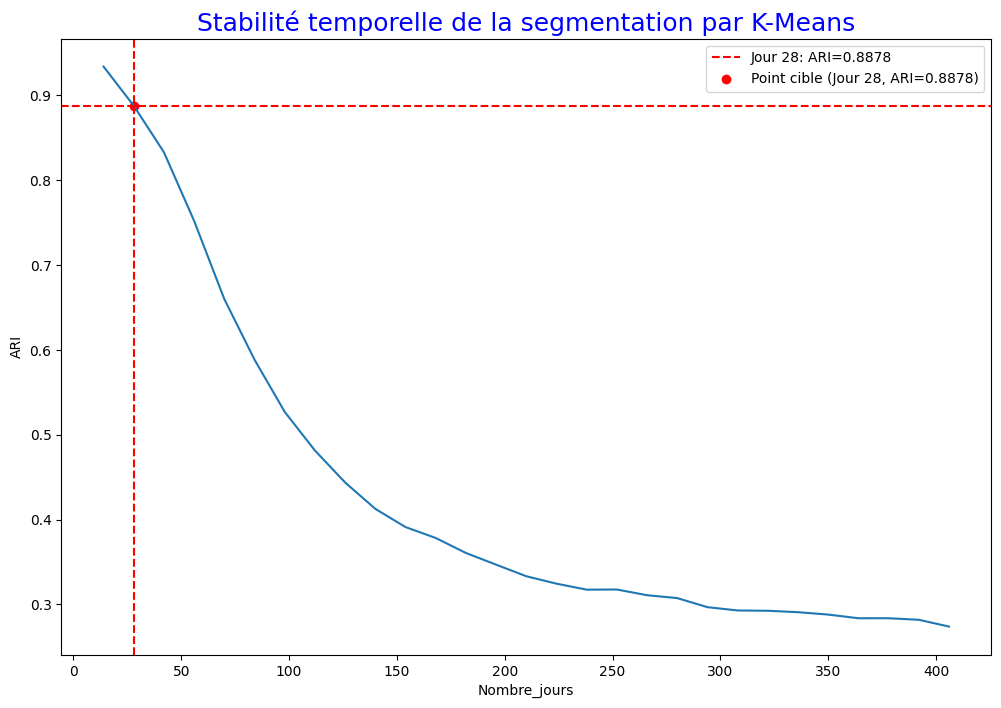

In [21]:
ari_score = pd.DataFrame(ari_scores, columns=["Nombre_jours", "ARI", "Date"])
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=ari_score, x="Nombre_jours", y="ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means", fontsize=18, color="b")

target_x = ari_score.iloc[1][0]
target_y = ari_score.iloc[1][1]
plt.axvline(
    x=target_x,
    color="red",
    linestyle="--",
    label=f"Jour {target_x}: ARI={target_y:.4f}",
)
plt.axhline(y=target_y, color="red", linestyle="--")
plt.scatter(
    target_x,
    target_y,
    color="red",
    marker="o",
    label=f"Point cible (Jour {target_x}, ARI={target_y:.4f})",
)

plt.legend()
plt.show()

La fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente doit être de 28 jours.  
Après 42 jours la segmentation risque de perdre toute son efficacité (ARI Score < 80).